# Classification of remote sensing data with adative attribute profiles

- Package install: **morphoaap**

In [ ]:
!pip install morphoaap

- input image download: pavia university

In [ ]:
!wget https://github.com/wonderalexandre/aap/raw/main/example/pavia_uni.mat

## 1. Importing common libraries


In [10]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import morphoaap as aap
from skimage.exposure import rescale_intensity

def rescale(np_img, vmin=0, vmax=255):
    bmax = np_img.max()
    bmin = np_img.min()
    return np.uint8((vmax-vmin) * (np_img - bmin) / (bmax - bmin) + vmin)

## 2. Function for dimensionality reduction with PCA

In [11]:
#return PCs
def getPCA(data, preserved_var = 0.99):

  # Reshape in a Matrix do apply PCA
  (nr, nc, nb) = data.shape
  data_vec = np.reshape(data, (nr*nc, nb))

  # PCA purposes
  Sigma = np.cov(data_vec.T)
  eigen_vals, eigen_vecs = np.linalg.eig(Sigma)

  # Compute the cummulative eigenvalue
  tot = sum(eigen_vals)
  var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
  cum_var_exp = np.cumsum(var_exp)

  # Reduce the space to keep 99% of the cummulative variance
  d_pca = np.where(cum_var_exp > preserved_var)[0][0]

  # Transformation Matrix
  W = eigen_vecs[:, 0:d_pca]

  # Transform data
  Dp = np.dot(data_vec, W)

  # Convert to an image vector
  return np.reshape(Dp, (nr, nc, d_pca))



 # 4. Function for feature extraction with AAP

In [12]:
def featureExtraction(image, lambdas, attributeType=0, deltaMSER=0):

  nr, nc, bands = image.shape
  image_vector = image.reshape((nr * nc, bands))

  number_of_images_profile = ((len(lambdas) * 2) + 1)
  number_of_images = number_of_images_profile * bands
  EAP = np.zeros((nr * nc, number_of_images))
  i = 0
  
  for band in range(bands):
    ap = aap.AttributeProfile(image_vector[:, band], nr, nc)
    if(deltaMSER == 0):
      #tradicional attribute profile
      profile = ap.getAP(lambdas, attributeType)
    else:
      #adaptive attribute profile
      profile = ap.getAAP(lambdas, attributeType, deltaMSER)

    EAP[:, i : i+number_of_images_profile] =  profile
    i = i + number_of_images_profile

  return EAP


## Example of EAPs and EAAPs

 - Function to plot profile images

In [29]:
def plotProfiles(profile, number_images_by_row):

        rows = number_of_images_profile // number_images_by_row
        last_cols = 0
        if(number_of_images_profile % number_images_by_row != 0):
            last_cols = number_of_images_profile % number_images_by_row
        num_rows = rows
        if(last_cols > 0):
            num_rows += 1
        num_cols = number_images_by_row
        if(rows == 0):
            num_rows = rows = 1
            num_cols = last_cols
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))
        if(num_rows == 1):
            for img in range(num_cols):
                axs[img].axis('off')
                axs[img].imshow(profile[:,:,img], cmap='gray')
                axs[img].set_title('Image: '+ str(img+1) )

        else:
            img = 0
            for l in range(num_rows):
                for c in range(3):
                    if( (l < rows or c < last_cols)):
                        axs[l,c].axis('off')
                        axs[l,c].imshow(profile[:,:,img], cmap='gray')
                        axs[l,c].set_title('Image: '+ str(img+1) )
                        img += 1

        #plt.savefig('./imagens.png')
        plt.show()



In [23]:
# load dataset: university of Pavia
pavia = scipy.io.loadmat('pavia_uni.mat')
image = pavia['pavia_uni']

image_pca = getPCA(image, preserved_var=0.992)
nr, nc, bands = image_pca.shape

for band in range(bands):
    image_pca[:, :, band] = rescale(image_pca[:, :, band])


lambdas = [100, 500, 1000, 5000]

EAP = featureExtraction(image_pca, lambdas, deltaMSER=0)
number_of_images_profile = ((len(lambdas) * 2) + 1)
number_of_images = number_of_images_profile * bands
EAP = EAP.reshape(nr, nc, number_of_images)
AP_band1 = EAP[:,:, 0:number_of_images_profile ]
AP_band2 = EAP[:,:,    number_of_images_profile:2*number_of_images_profile ]
AP_band3 = EAP[:,:, 2*number_of_images_profile:3*number_of_images_profile ]
AP_band4 = EAP[:,:, 3*number_of_images_profile:4*number_of_images_profile ]

EAAP = featureExtraction(image_pca, lambdas, deltaMSER=19)
EAAP = EAAP.reshape(nr, nc, number_of_images)
AAP_band1 = EAAP[:,:, 0:number_of_images_profile ]
AAP_band2 = EAAP[:,:,    number_of_images_profile:2*number_of_images_profile ]
AAP_band3 = EAAP[:,:, 2*number_of_images_profile:3*number_of_images_profile ]
AAP_band4 = EAAP[:,:, 3*number_of_images_profile:4*number_of_images_profile ]

Attribute Profile


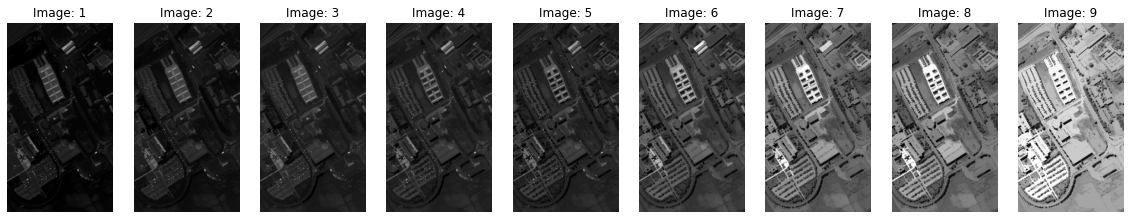

In [30]:
print("Attribute Profile")
plotProfiles(AP_band1, number_of_images_profile)

Adaptive Attribute Profile


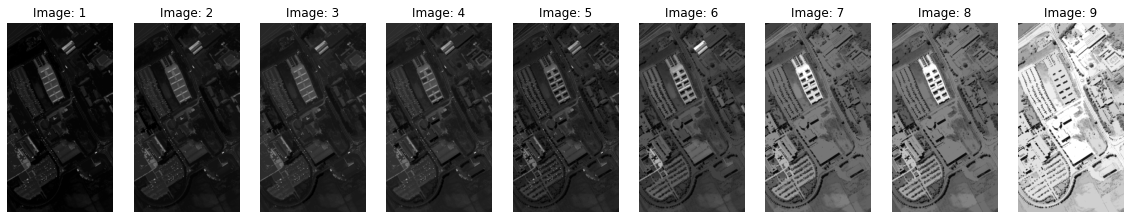

In [31]:
print("Adaptive Attribute Profile")
plotProfiles(AAP_band1, number_of_images_profile)

Difference between AP and AAP


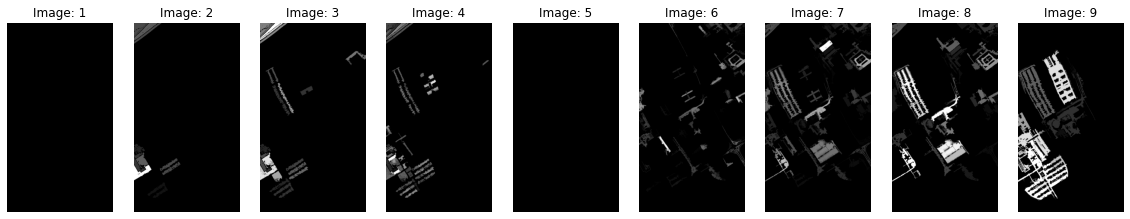

In [32]:
print("Difference between AP and AAP")
plotProfiles(np.abs(AP_band1 - AAP_band1), number_of_images_profile)

# 5. Training model



In [9]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sklearn.ensemble import RandomForestClassifier

class RandomForestBasedAttributeProfile(RandomForestClassifier):

  def __init__(self, n_estimators = 100, criterion='gini', max_depth=None, bootstrap=True,  max_features = "sqrt",  random_state=42, image = None, lambdas=[100, 500, 1000, 5000], attributeType=0, deltaMSER=0):
    super().__init__(n_estimators = n_estimators, criterion=criterion, max_depth=max_depth, bootstrap=bootstrap,  max_features = max_features, random_state=random_state)
    self.lambdas = lambdas
    self.attributeType = attributeType
    self.deltaMSER = deltaMSER
    self.image = image
    self.EAP_vector = featureExtraction(self.image, self.lambdas, self.attributeType, deltaMSER=self.deltaMSER)


  def fit(self, idx, y):
    X = self.EAP_vector[idx]
    super().fit(X, y)
    return self

  def predict(self, idx):
    X = self.EAP_vector[idx]
    return super().predict(X)



from itertools import product
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
class GridSearch():

    def __init__(self, parameters, cv=5, X_val=None, y_val=None):
        self.parameters = parameters
        self.cv=cv
        self.X_val=X_val
        self.y_val=y_val

    def product_dict(self, dic):
        keys = dic.keys()
        vals = dic.values()
        for instance in product(*vals):
            yield dict(zip(keys, instance))

    def bestParameter(self, param):
        return self.parameters_list[max(self.accuracyBest, key=self.accuracyBest.get)][param]

    def bestParameters(self):
        return self.parameters_list[max(self.accuracyBest, key=self.accuracyBest.get)]

    def bestModel(self):
        return self.models[max(self.accuracyBest, key=self.accuracyBest.get)]

    def plot(self, param):
      # Plot it
      plt.figure(figsize=(14, 8))
      plt.style.use('ggplot')
      plt.step(list(self.accuracyBest.keys()), list(self.accuracyBest.values()), where='mid', color='blue')

      bestDelta = self.bestParameter(param)
      plt.plot(bestDelta, self.accuracyBest[bestDelta], 'o', color='red');
      plt.xlabel('$\Delta$')
      plt.ylabel('Accuracy')
      #plt.savefig('./analiseDelta.svg')
      plt.show()

    def fit(self, X, y):

        kf = StratifiedKFold(n_splits=self.cv,  shuffle=True)
        self.accuracyBest = {}
        self.parameters_list = []
        self.models = []
        cont = 1
        for params in self.product_dict(self.parameters):

            print (".") if cont % 10 == 0 else print(".", end=" ")
            cont += 1

            n_estimators = params['n_estimators']
            bootstrap = params['bootstrap']
            max_features = params['max_features']
            max_depth = params['max_depth']
            criterion = params['criterion']
            random_state = params['random_state']
            image = params['image']
            lambdas = params['lambdas']
            attributeType = params['attributeType']
            deltaMSER = params['deltaMSER']

            accuracy = []

            model = RandomForestBasedAttributeProfile(n_estimators = n_estimators,
                                                  bootstrap=bootstrap,
                                                  max_features = max_features,
                                                  max_depth = max_depth,
                                                  criterion = criterion,
                                                  random_state=random_state,
                                                  image=image,
                                                  lambdas=lambdas,
                                                  attributeType=attributeType,
                                                  deltaMSER=deltaMSER)

            if(self.X_val is None):
                for train_index, test_index in kf.split(X, y):
                    X_train, X_val = X[train_index], X[test_index]
                    y_train, y_val = y[train_index], y[test_index]

                    model.fit(X_train, y_train)
                    y_pred_val = model.predict(X_val)
                    accuracy.append( np.mean(y_val == y_pred_val) )
            else:
                model.fit(X, y)
                y_pred_val = model.predict(self.X_val)
                accuracy.append( np.mean(self.y_val == y_pred_val) )

            #print(deltaMSER, np.mean(accuracy))
            self.accuracyBest[len(self.accuracyBest)] = np.mean(accuracy)
            self.parameters_list.append(params)
            self.models.append(model)


from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, recall_score
import pandas as pd
from IPython.display import display

def getMetrics(y_train, y_test, yp_train, yp_pred):

    df = pd.DataFrame({"Metrics": ["Overall Accuracy", "Average Accuracy", "kappa Coefficient"],
              "Train": [accuracy_score(y_train, yp_train), recall_score(y_train, yp_train, average="macro"), cohen_kappa_score(y_train, yp_train)],
              "Test":  [accuracy_score(y_test, yp_pred), recall_score(y_test, yp_pred, average="macro"), cohen_kappa_score(y_test, yp_pred)]})
    df.set_index("Metrics")

    AA_classes_train = recall_score(y_train, yp_train, average=None, labels=np.unique(y_train))
    AA_classes_test = recall_score(y_test, yp_pred, average=None, labels=np.unique(y_test))
    df_classes = pd.DataFrame({"Classes":np.unique(y_train), "Train": AA_classes_train, "Test": AA_classes_test})
    df_classes.set_index("Classes")

    return df, df_classes


# Applied classifier

## 1. Experiments performed with the University of Pavia dataset

. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. 

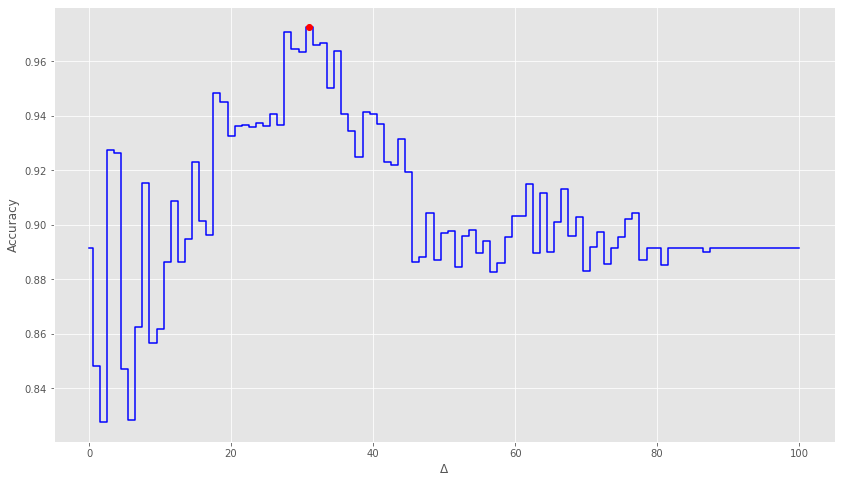

,Classification model,Attribute,Thresholds,OA% (Train),OA% (Test),AA% (Test),Kappa% (Test)
0,Results reported in Dalla Mura et al. 2010,Area,"[100, 500, 1000, 5000]",-,0.923200,0.920000,0.900000
1,(Retest) Dalla Mura et al. 2010,Area,"[100, 500, 1000, 5000]",1.000000,0.891388,0.927341,0.857174
2,Dalla Mura et al. 2010 with AAP,Area,Delta = 31,1.000000,0.972695,0.979623,0.964024


In [10]:
# load dataset: university of Pavia
pavia = scipy.io.loadmat('pavia_uni.mat')
image = pavia['pavia_uni']
test = pavia['pavia_uni_ts']
train = pavia['pavia_uni_tr']

# Train and test sets
train = train.reshape(-1)
test = test.reshape(-1)
idx_train = np.array(np.where(train>0)).reshape(-1)
idx_test = np.array(np.where(test>0)).reshape(-1)
y_train = train[idx_train]
y_test  = test[idx_test]

#PCA
image_pca = getPCA(image, preserved_var=0.992)
bands = image_pca.shape[2]
for band in range(bands):
  image_pca[:, :, band] = rescale(image_pca[:, :, band])

lambdas = [100, 500, 1000, 5000]
attributeType = 0 #Currently only the area attribute is available

modelAP = RandomForestBasedAttributeProfile(n_estimators = 100,
                                          bootstrap=True,
                                          max_features = "sqrt",
                                          criterion= 'gini',
                                          random_state=42,
                                          image=image_pca,
                                          lambdas=lambdas,
                                          attributeType=attributeType
                                          )


modelAP.fit(idx_train, y_train)

#grid search / training
parameters_grid ={
    "n_estimators": [100],
    "bootstrap": [True],
    "max_features": ["sqrt"],
    "max_depth" : [None],
    "criterion" :["gini"],
    "random_state": [42],
    "image": [image_pca],
    "lambdas": [lambdas],
    "attributeType": [attributeType],
    "deltaMSER": [i for i in range(0, 40)]
}
gridsearch = GridSearch(parameters_grid, X_val=idx_test, y_val=y_test)
gridsearch.fit(idx_train, y_train)
gridsearch.plot("deltaMSER")
bestDelta = gridsearch.bestParameter("deltaMSER")
modelAAP = gridsearch.bestModel()


#Performance
yp_train_AP = modelAP.predict(idx_train)
yp_test_AP = modelAP.predict(idx_test)

yp_train_AAP = modelAAP.predict(idx_train)
yp_test_AAP = modelAAP.predict(idx_test)


df_AAP, df_classes_AAP = getMetrics(y_train, y_test, yp_train_AAP, yp_test_AAP)
df_AP, df_classes_AP = getMetrics(y_train, y_test, yp_train_AP, yp_test_AP)
dfResults = pd.DataFrame({
                  "Classification model" : ["Results reported in Dalla Mura et al. 2010", "(Retest) Dalla Mura et al. 2010", "Dalla Mura et al. 2010 with AAP"],
                   "Attribute" : ["Area", "Area", "Area"],
                   "Thresholds" : [lambdas, lambdas, ("Delta = " + str(bestDelta))],

                   "OA% (Train)" : ["-", df_AP["Train"][0], df_AAP["Train"][0]],
                   "OA% (Test)" : [0.9232, df_AP["Test"][0], df_AAP["Test"][0]],
                   "AA% (Test)" : [0.9200, df_AP["Test"][1], df_AAP["Test"][1]],
                   "Kappa% (Test)" : [0.90, df_AP["Test"][2], df_AAP["Test"][2]]}).style.set_caption('<br><br>The parameters for building the model were extracted from: <i>M. Dalla Mura, J. Atli Benediktsson, B. Waske, and L. Bruzzone, "Extended profiles with morphological attribute filters for the analysis of hyperspectral data", Int. J. Remote Sens., vol. 31, no. 22, pp. 5975–5991, Jul. 2010.</i><br><br>')
dfResults